# Optimization I Project 1
# Group 9 - Aniket Patil, Anudeep Akkana, Shreyansh Agrawal, Jason Nania


### Problem Description

Marketing budgets now comprise 11 percent of total company budgets, based on a CMO survey 
sponsored by the Fuqua School of Business at Duke University, Deloitte LLP, and the American 
Marketing Association. However, the effectiveness of marketing varies significantly: on the one hand, 
P&G cut more than $100 million in digital marketing spending because their digital ads were largely 
ineffective; on the other hand, Netflix plans a 54% boost in ad spending because they got very positive 
feedback in international markets. 
 
One potential reason for such variation is the way of making marketing budget allocations. Namely, how 
much to invest in each advertisement platform. As stated in the Handbook of Marketing Analytics: 
 
...budget decisions are often based on gut feelings or on the negotiation skills of individual 
managers. Consequently, politics and individual opinions tend to shape the decision process 
instead of fact-based discussions. Obviously, these rules and practices bear the risk of results far 
away from the optimal, profit-maximizing budget. 
 
Indeed, the marketing strategy of Netflix seems to be steered by data.  
 
In this project, we use linear programming to build a simple marketing budget allocation strategy. 

In [1]:
!pip install gurobipy

In [2]:
import numpy as np
import gurobipy as gp

from gurobipy import *
from gurobipy import quicksum
from gurobipy import Model
from gurobipy import GRB
import pandas as pd

# Reading the CSV files

In [3]:
# reading the ROI data from provided Excel "ROI_data"
ROI = pd.read_csv(r'ROI_data.csv')
ROI = ROI.set_index('Platform') # set index of ROI
var_names = ROI.columns.tolist()
ROI

,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
Platform,,,,,,,,,,
ROI,0.031,0.049,0.024,0.039,0.016,0.024,0.046,0.026,0.033,0.044
Second Firms ROI Estimate,0.049,0.023,0.024,0.039,0.044,0.046,0.026,0.019,0.037,0.026


In [4]:
# reading the ROI data from provided Excel "roi_mat"
df_roi = pd.read_csv(r"roi_mat.csv")

# converting the percentages to decimals
for col in var_names:
    df_roi[col] = df_roi[col].apply(lambda x : x/100)

df_roi.rename(columns = {'Unnamed: 0':'Months'},inplace=True)
    
df_roi


,Months,Print,TV,SEO,AdWords,Facebook,LinkedIn,Instagram,Snapchat,Twitter,Email
0,January,0.040,0.036,0.024,0.039,0.030,0.035,0.036,0.0225,0.035,0.035
1,February,0.040,0.039,0.027,0.038,0.043,0.032,0.027,0.0180,0.037,0.035
2,March,0.035,0.029,0.031,0.038,0.024,0.041,0.037,0.0260,0.042,0.025
3,April,0.038,0.031,0.024,0.044,0.024,0.038,0.037,0.0250,0.036,0.029
4,May,0.035,0.032,0.019,0.034,0.027,0.027,0.039,0.0220,0.045,0.039
5,June,0.040,0.032,0.027,0.034,0.034,0.030,0.045,0.0210,0.038,0.041
6,July,0.039,0.036,0.020,0.044,0.039,0.037,0.043,0.0180,0.040,0.038
7,August,0.042,0.033,0.028,0.042,0.020,0.037,0.036,0.0150,0.044,0.043
8,September,0.041,0.028,0.025,0.042,0.029,0.037,0.028,0.0250,0.040,0.034
9,October,0.030,0.030,0.031,0.046,0.031,0.033,0.032,0.0230,0.025,0.032


# Question 3

Formulate the marketing budget allocation problem as a linear program. Use gurobi to find the optimal budget allocation.

In [5]:
# define the budget here in millions of dollars
budget = 10

In [6]:
opt_mod_1 = Model(name = "linearprogram") # intinitalizing the model
var_names = ROI.columns.tolist()
roi = ROI.iloc[0].values

x = opt_mod_1.addVars(len(var_names),name=var_names) # setting up the variables for Gurobi model
obj_fn = opt_mod_1.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

######  defining constrains #####
# 1-10. first 10 contrains that allocation can't be greater than $3M
# 11. The amount invested in print and TV should be no more than the amount spent on Facebook and Email
# 12. The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.
# 13. total sum of all the spend should not be more than $10M 

contrain_rhs = np.array([3,3,3,3,3,3,3,3,3,3,0,0,budget]) # rhs of the constraints
cont_eqn_coeff = np.identity(10) #1-10 constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,0,0,-1,0,0,0,0,-1]],axis=0) # 11. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0) # 12. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0) #13. constrain equation coeff.

n_constrains = len(contrain_rhs) # total number of constrains
con = []
n_vars = len(var_names) # total number of variables

# looping through each constrain and adding them to the optimization model one at every loop iteration
for i in range(n_constrains):
    c = opt_mod_1.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=contrain_rhs[i],name='Const_'+str(i))
    con.append(c)

###########

opt_mod_1.Params.OutputFlag=0 # not printing the intermediary output for code sanity
opt_mod_1.optimize() #solving the model

#printing the budget allocation in each channel
max_obj_1  = opt_mod_1.objVal
print('Objective Function Value: $' + str(round(opt_mod_1.objVal,4)) + "M")
budget_alloc_1 = []
# Get values of the decision variables
for v in opt_mod_1.getVars():
    #print('%s: %g'  %  (v.varName, v.x))
    budget_alloc_1.append(v.x)

df_allocations_1 = pd.DataFrame(zip(var_names,budget_alloc_1), columns=['Platform','Budget Allocation ($M)'])
df_allocations_1

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-14
Objective Function Value: $0.456M


,Platform,Budget Allocation ($M)
0,Print,0.0
1,TV,3.0
2,SEO,0.0
3,AdWords,1.0
4,Facebook,0.0
5,LinkedIn,0.0
6,Instagram,3.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,3.0


### This means that the maximum expected ROI should be $ 0.456 Millions

### USD 3M should be allocated towards TV, Instagram, and Email, and USD 1M should be allocated towards AdWords. We should not allocate any budget to the remaining channels.

# Question 4 

Your boss is happy to see the promising results presented by the marketing department. 
However, your boss is also very concerned because your boss recalls being somewhat 
disappointed after following such recommendations in the past. To be cautious about the 
decision, your team has decided to get another opinion about the ROI data and rerun the 
analysis. The second consulting firm returns the estimates of the ROI data in the table below 
(also in the CSV file mentioned above). You are asked to compare the two optimal allocations 
from these two ROI estimates

In [7]:
opt_mod = Model(name = "linearprogram") # intinitalizing the model
roi = ROI.iloc[1].values # reading the 2nd set of roi values

x = opt_mod.addVars(len(var_names),name=var_names) # setting up the variables for Gurobi model
obj_fn = opt_mod.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

######  defining constrains #####
# 1-10. first 10 contrains that allocation can't be greater than $3M
# 11. The amount invested in print and TV should be no more than the amount spent on Facebook and Email
# 12. The total amount used in social media (Facebook, LinkedIn, Instagram, Snapchat, and Twitter) should be at least twice of SEO and AdWords.
# 13. total sum of all the spend should not be more than $10M 

contrain_rhs = np.array([3,3,3,3,3,3,3,3,3,3,0,0,budget]) # rhs of the constraints
cont_eqn_coeff = np.identity(10) #1-10 constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,0,0,-1,0,0,0,0,-1]],axis=0) # 11. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0) # 12. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0) #13. constrain equation coeff.

n_constrains = len(contrain_rhs) # total number of constrains
con = []
n_vars = len(var_names) # total number of variables

# looping through each constrain and adding them to the optimization model one at every loop iteration
for i in range(n_constrains):
    c = opt_mod.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=contrain_rhs[i],name='Const_'+str(i))
    con.append(c)

###########

opt_mod.Params.OutputFlag=0 # not printing the intermediary output for code sanity
opt_mod.optimize() #solving the model

#printing the budget allocation in each channel
max_obj_2  = opt_mod.objVal
print('Objective Function Value: $' + str(round(opt_mod.objVal,4)) + "M")
budget_alloc_2 = []
# Get values of the decision variables
for v in opt_mod.getVars():
    #print('%s: %g'  %  (v.varName, v.x))
    budget_alloc_2.append(v.x)

df_allocations_2 = pd.DataFrame(zip(var_names,budget_alloc_2), columns=['Platform','Budget Allocation ($M)'])
df_allocations_2

Objective Function Value: $0.456M


,Platform,Budget Allocation ($M)
0,Print,3.0
1,TV,0.0
2,SEO,0.0
3,AdWords,1.0
4,Facebook,3.0
5,LinkedIn,3.0
6,Instagram,0.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,0.0


### Maximum ROI is still $ 0.456 Millions similar to first ROI data. However, the budget allocation for each platform has changed. In this case, USD 3M should be allocated towards Print, Facebook, and LinkedIn, and USD 1M should be allocated towards AdWords.

# Question 5

Are the allocations the same? Assuming the first ROI data is correct, if you were to use the 
second allocation (the allocation that assumed the second ROI data was correct) how much 
lower would the objective be relative to the optimal objective (the one that uses the first ROI 
data and the first allocation)? Assuming the second ROI data is correct, if you used the first 
allocation how much lower would the objective be relative to the optimal objective? Do you 
think the third constraint above, based on your boss’ experience, is useful?

The company will allocate the budget towards four different platforms in both the cases, but the platforms chosen for allocation and the money allocated are different. Below is the comparison of the same:

,Channel,Allocation 1,Allocation 2
0,Print,0.0,3.0
1,TV,3.0,0.0
2,SEO,0.0,0.0
3,AdWords,1.0,1.0
4,Facebook,0.0,3.0
5,LinkedIn,0.0,3.0
6,Instagram,3.0,0.0
7,Snapchat,0.0,0.0
8,Twitter,0.0,0.0
9,Email,3.0,0.0


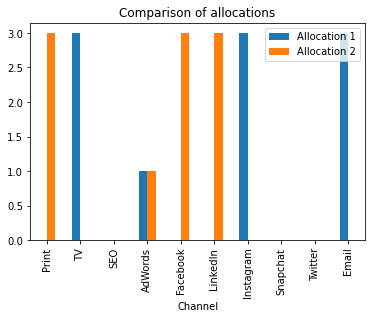

In [8]:
df_compare = pd.DataFrame(zip(var_names, budget_alloc_1, budget_alloc_2), columns=['Channel','Allocation 1','Allocation 2'])
df_compare.plot(kind='bar',x='Channel',stacked=False, title="Comparison of allocations")
df_compare.head(10)

In [9]:
roi1 = ROI.iloc[0].values
obj_val_1_2 = np.dot(roi1, np.array(budget_alloc_2))
print("Using 1st ROI data on 2nd Allocation")
print("If we use the 1st ROI data and use 2nd allocation, then out objective function would be: " + str(obj_val_1_2))
print("This would be lower than the original objective function of value: " + str(round(max_obj_1,4)) + " by " + str(round(max_obj_1-obj_val_1_2,4)))
print("\n")

roi2 = ROI.iloc[1].values
obj_val_2_1 = np.dot(roi2, np.array(budget_alloc_1))
print("Using 2nd ROI data on 1st Allocation")
print("If we use the 2nd ROI data and use 1st allocation, then out objective function would be: " + str(obj_val_2_1))
print("This would be lower than the original objective function of value: " + str(round(max_obj_2,4)) + " by " + str(round(max_obj_2-obj_val_2_1,4)))


Using 1st ROI data on 2nd Allocation
If we use the 1st ROI data and use 2nd allocation, then out objective function would be: 0.252
This would be lower than the original objective function of value: 0.456 by 0.204


Using 2nd ROI data on 1st Allocation
If we use the 2nd ROI data and use 1st allocation, then out objective function would be: 0.264
This would be lower than the original objective function of value: 0.456 by 0.192


Let's now try to check if the constraints that boss imposed on budget allocations had an impact, what if we remove them...

In [10]:
opt_mod = Model(name = "linearprogram") # intinitalizing the model
roi = ROI.iloc[0].values # reading the 2nd set of roi values

x = opt_mod.addVars(len(var_names),name=var_names) # setting up the variables for Gurobi model
obj_fn = opt_mod.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

######  defining constrains #####
# 13. total sum of all the spend should not be more than $10M 

contrain_rhs = np.array([0,0,budget]) # rhs of the constraints
cont_eqn_coeff = np.array([[1,1,0,0,-1,0,0,0,0,-1]]) # 11. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0) # 12. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0) #13. constrain equation coeff.

n_constrains = len(contrain_rhs) # total number of constrains
con = []
n_vars = len(var_names) # total number of variables

# looping through each constrain and adding them to the optimization model one at every loop iteration
for i in range(n_constrains):
    c = opt_mod.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=contrain_rhs[i],name='Const_'+str(i))
    con.append(c)

###########

opt_mod.Params.OutputFlag=0 # not printing the intermediary output for code sanity
opt_mod.optimize() #solving the model

#printing the budget allocation in each channel
max_obj_1_w_o_boss  = opt_mod.objVal
print('Objective Function Value: $' + str(round(opt_mod.objVal,4)) + "M")
budget_alloc_1 = []
# Get values of the decision variables
for v in opt_mod.getVars():
    #print('%s: %g'  %  (v.varName, v.x))
    budget_alloc_1.append(v.x)

df_allocations_1 = pd.DataFrame(zip(var_names,budget_alloc_1), columns=['Platform','Budget Allocation ($M)'])
df_allocations_1.head(10)


Objective Function Value: $0.465M


,Platform,Budget Allocation ($M)
0,Print,0.0
1,TV,5.0
2,SEO,0.0
3,AdWords,0.0
4,Facebook,0.0
5,LinkedIn,0.0
6,Instagram,0.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,5.0


In [11]:
print("If we remove the third constraint, we can see that the maximum objective function will go up by: $"+ str(round(max_obj_1_w_o_boss-max_obj_1,5)) +"M")
print("But this might not be the way to go as we are just utilizing two channels which could have diminishing returns")

If we remove the third constraint, we can see that the maximum objective function will go up by: $0.009M
But this might not be the way to go as we are just utilizing two channels which could have diminishing returns


In [12]:
opt_mod = Model(name = "linearprogram") # intinitalizing the model
roi = ROI.iloc[1].values # reading the 2nd set of roi values

x = opt_mod.addVars(len(var_names),name=var_names) # setting up the variables for Gurobi model
obj_fn = opt_mod.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

######  defining constrains #####
# 13. total sum of all the spend should not be more than $10M 

contrain_rhs = np.array([0,0,budget]) # rhs of the constraints
cont_eqn_coeff = np.array([[1,1,0,0,-1,0,0,0,0,-1]]) # 11. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0) # 12. constrain equation coeff.
cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0) #13. constrain equation coeff.

n_constrains = len(contrain_rhs) # total number of constrains
con = []
n_vars = len(var_names) # total number of variables

# looping through each constrain and adding them to the optimization model one at every loop iteration
for i in range(n_constrains):
    c = opt_mod.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=contrain_rhs[i],name='Const_'+str(i))
    con.append(c)

###########

opt_mod.Params.OutputFlag=0 # not printing the intermediary output for code sanity
opt_mod.optimize() #solving the model

#printing the budget allocation in each channel
max_obj_2_w_o_boss  = opt_mod.objVal
print('Objective Function Value: $' + str(round(opt_mod.objVal,4)) + "M")
budget_alloc_2 = []
# Get values of the decision variables
for v in opt_mod.getVars():
    #print('%s: %g'  %  (v.varName, v.x))
    budget_alloc_2.append(v.x)

df_allocations_2 = pd.DataFrame(zip(var_names,budget_alloc_2), columns=['Platform','Budget Allocation ($M)'])
df_allocations_2.head(10)


Objective Function Value: $0.465M


,Platform,Budget Allocation ($M)
0,Print,5.0
1,TV,0.0
2,SEO,0.0
3,AdWords,0.0
4,Facebook,5.0
5,LinkedIn,0.0
6,Instagram,0.0
7,Snapchat,0.0
8,Twitter,0.0
9,Email,0.0


In [13]:
print("If we remove the third constraint, we can see that the maximum objective function will go up by: $"+ str(round(max_obj_2_w_o_boss-max_obj_2,5)) +"M")
print("But this might not be the way to go as we are just utilizing two channels which could have diminishing returns")

If we remove the third constraint, we can see that the maximum objective function will go up by: $0.009M
But this might not be the way to go as we are just utilizing two channels which could have diminishing returns


# Question 6 

To explore this further perform some analysis of how your optimal allocation would change 
based on changes in the ROI data.  Use the first ROI data as your starting point.  By how much 
could each advertising medium’s ROI increase or decrease and still result in the same optimal 
allocation you found in step (3)? 

In [14]:
#opt_mod_1.printAttr(['X','Obj','SAObjLow','SAObjUp'])
df_sensitivity = pd.DataFrame()
df_sensitivity['Platform'] = var_names
df_sensitivity['Min ROI'] = opt_mod_1.SAObjLow
df_sensitivity['Curr ROI'] = ROI.iloc[0].values
df_sensitivity['Max ROI'] = opt_mod_1.SAObjUp
df_sensitivity

,Platform,Min ROI,Curr ROI,Max ROI
0,Print,-inf,0.031,0.049
1,TV,0.039,0.049,0.062
2,SEO,-inf,0.024,0.039
3,AdWords,0.033,0.039,0.046
4,Facebook,-inf,0.016,0.029
5,LinkedIn,-inf,0.024,0.039
6,Instagram,0.039,0.046,inf
7,Snapchat,-inf,0.026,0.039
8,Twitter,-inf,0.033,0.039
9,Email,0.029,0.044,inf


Above is the table which highlights how much can we tweak the ROI for each platform to maintain the same optimal solution found in step (3)

# Question 7 

In [15]:
budget_n = budget # creating a new variable to update budget in each iteration

# for each month the budget will be 10 + 0.5*ROI(from previous month)

budget_allocation_list = []

for r in range(len(df_roi)):

    model = Model()
    x = model.addVars(len(var_names),name=var_names)

    # defining constrains
    contrain_rhs = np.array([3,3,3,3,3,3,3,3,3,3,0,0,budget_n])
    cont_eqn_coeff = np.identity(10)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,0,0,-1,0,0,0,0,-1]],axis=0)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[0,0,2,2,-1,-1,-1,-1,-1,0]],axis=0)
    cont_eqn_coeff = np.append(cont_eqn_coeff,[[1,1,1,1,1,1,1,1,1,1]],axis=0)
    
    #roi for each month
    roi = np.array(df_roi.loc[:,var_names])[r]

    # maximizing the roi for each month based on that month's roi
    objective = model.setObjective(quicksum(roi[i]*x[i] for i in range(len(var_names))),GRB.MAXIMIZE)

    n_constrains = len(contrain_rhs)
    con = []
    n_vars = len(var_names)

    for i in range(n_constrains):
        c = model.addConstr(quicksum(cont_eqn_coeff[i,j]*x[j] for j in range(n_vars))<=contrain_rhs[i],name='Const_'+str(i))
        con.append(c)
        
    model.Params.OutputFlag = 0
    model.optimize() 

    roi_val = model.ObjVal
    budget_n = budget+0.5*roi_val # adding half of the roi to to the original budget i.e. $10M
    budget_allocation_list.append(model.X)

# outputing the budget allocations for each channel by months
coef_by_iterations = np.array(budget_allocation_list).T
coef_df = pd.DataFrame(coef_by_iterations, columns=df_roi['Months'], index=var_names)
coef_df.round(2)


Months,January,February,March,April,May,June,July,August,September,October,November,December
Print,3.00,3.00,0.0,0.0,1.2,3.00,0.00,2.71,0.61,0.0,3.00,3.00
TV,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,2.11
SEO,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
AdWords,1.33,2.40,3.0,3.0,0.0,0.00,3.00,1.50,3.00,3.0,1.19,0.00
Facebook,0.00,3.00,0.0,0.0,0.0,0.00,1.21,0.00,0.00,0.0,0.00,3.00
LinkedIn,0.00,0.00,3.0,3.0,0.0,0.00,0.00,0.00,3.00,3.0,0.00,0.00
Instagram,2.67,0.00,1.2,3.0,3.0,3.00,3.00,0.00,0.00,3.0,3.00,0.00
Snapchat,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00
Twitter,0.00,1.79,3.0,1.2,3.0,1.21,3.00,3.00,3.00,0.0,0.00,0.00
Email,3.00,0.00,0.0,0.0,3.0,3.00,0.00,3.00,0.61,1.2,3.00,2.11


# Question 8 

A stable budget is defined as a monthly allocation such that for each platform the monthly 
change in spend is no more than $1M. Is the allocation you found stable? If it isn’t, you do not 
need to solve a new optimization model. Describe how my might model this?

In [16]:

df_diff = pd.DataFrame(index=var_names, columns=df_roi['Months'])

for i in range(len(var_names)):

    allocation_1 = np.array(coef_df.iloc[i])
    allocation_2 = np.insert(allocation_1[:-1],0,allocation_1[0])
    diff = allocation_1-allocation_2
    df_diff.iloc[i]=diff

df_diff.round(2)

# note suppose it says some value in a month, it means the ad of that month minus add of its previous month, hence for Janurary this column is 0

Months,January,February,March,April,May,June,July,August,September,October,November,December
Print,0.0,0.0,-3.0,0.0,1.200168,1.799832,-3.0,2.714132,-2.104634,-0.609498,3.0,0.0
TV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.110404
SEO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AdWords,0.0,1.062167,0.6045,0.0,-3.0,0.0,3.0,-1.5,1.5,0.0,-1.814278,-1.185722
Facebook,0.0,3.0,-3.0,0.0,0.0,0.0,1.211905,-1.211905,0.0,0.0,0.0,3.0
LinkedIn,0.0,0.0,3.0,0.0,-3.0,0.0,0.0,0.0,3.0,0.0,-3.0,0.0
Instagram,0.0,-2.666667,1.203148,1.796852,0.0,0.0,0.0,-3.0,0.0,3.0,0.0,-3.0
Snapchat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Twitter,0.0,1.791,1.209,-1.796242,1.796242,-1.794497,1.794497,0.0,0.0,-3.0,0.0,0.0
Email,0.0,-3.0,0.0,0.0,3.0,0.0,-3.0,3.0,-2.390502,0.591858,1.798644,-0.889596


From the above, we can see that there are certain months where the budget allocation fluctuates by more than $1M. Hence, the allocations are not stable. This is not ideal in the sense that we can't keep jumping from one platform to another - it might cause an adverse effect on customer reach since we are stopping the marketing campaigns abruptly.

Our solution is not stable due to the methodology that we have adopted. We are trying to allocate the budgets by maximizing each month's ROI by considering that month's ROI, hence there is too much variation.

To get a stable solution, we can use one ROI i.e. the ROI provided initially in Part 1 to perform the budget allocation and use monthly ROI to calculate the ROIs for each month and add half of it to the next month's ROI